In [32]:
import mpmath as mp
from mpmath import *

# Plus basses sont les valeurs de phi0 qu'on veut explorer, plus haut on met dps, et plus on fine tune alpha_max
mp.dps = 500
mp.prec = 166

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

lnMpinGev = mp.mpf('42.334')
Mp = mp.exp(lnMpinGev)
Pstar = mp.mpf('2.2030e-9')

def norm_potential(x,alpha,phi0):
    return x**mp.mpf('2')-mp.mpf('2')/3*alpha*x**6+alpha/mp.mpf('5')*x**10

def norm_eps1(x,alpha,phi0):
    return mp.mpf('450')*(mp.mpf('1')+alpha*x**4*(-mp.mpf('2')+x**4))**2/((phi0*x)**mp.mpf('2')*(mp.mpf('15')+alpha*x**4*(-mp.mpf('10')+mp.mpf('3')*x**4))**2)

def norm_eps2(x,alpha,phi0):
    return (mp.mpf('60')*(mp.mpf('15')+alpha*x**mp.mpf('4')*(mp.mpf('40')+x**mp.mpf('4')*(-mp.mpf('78')+alpha*(mp.mpf('20')+mp.mpf('3')*x**8)))))/(phi0**2*x**2*(mp.mpf('15')+alpha*x**mp.mpf('4')*(-mp.mpf('10')+mp.mpf('3')*x**4))**2)
       
def x_endinf(alpha,phi0):
    xstart = mp.mpf('0.9841521')
    return mp.findroot(lambda x : norm_eps1(x,alpha,phi0)-mp.mpf('1'), xstart,solver='halley', verbose = False)

def efold_primitive(x,alpha,phi0):
    aplus=-alpha+mp.sqrt((alpha**2-alpha)*mp.mpc('1','0'))
    aminus=-alpha-mp.sqrt((alpha**2-alpha)*mp.mpc('1','0'))
    bplus=mp.mpf('2')*(aplus+alpha/mp.mpf('3'))/(aplus-aminus)
    bminus=mp.mpf('2')*(aminus+alpha/mp.mpf('3'))/(aminus-aplus)
    return phi0**2*(mp.re(x**2/20+bplus/(10*mp.sqrt(aplus))*mp.atan(mp.sqrt(aplus)*x**2)+bminus/(10*mp.sqrt(aminus))*mp.atan(mp.sqrt(aminus)*x**2)))

def get_calfconst_rrad(lnRrad,Pstar,epsEnd,potEnd):
    cmbMeasuredQuart = mp.mpf('0.25')*mp.log(Pstar*mp.mpf('8')*mp.pi**2)
    kstar, lnMpcToKappa, HubbleSquareRootOf3OmegaRad, RelatDofRatio = mp.mpf('0.05'), mp.mpf('130.282'), mp.mpf('7.5437e-63'), mp.mpf('1')
    N0 = mp.log(kstar) - lnMpcToKappa - mp.mpf('0.5')*mp.log(HubbleSquareRootOf3OmegaRad) - mp.mpf('0.25')*mp.log(RelatDofRatio)
    return - N0 + cmbMeasuredQuart-mp.mpf('0.25')*mp.log(potEnd/(mp.mpf('3')-epsEnd)) + lnRrad

def x_rrad(alpha,phi0,lnRrad,Pstar):
    xEnd = x_endinf(alpha,phi0)
    epsOneEnd = norm_eps1(xEnd,alpha,phi0)
    potEnd = norm_potential(xEnd,alpha,phi0)
    primEnd = efold_primitive(xEnd,alpha,phi0)
    calF = get_calfconst_rrad(lnRrad,Pstar,epsOneEnd,potEnd)
    calFplusNuEnd = calF+primEnd
    x_eps10 = 1
    return mp.findroot(lambda x : find_x_rrad(x, alpha, phi0,calFplusNuEnd), mp.mpf('1'), solver='halley', verbose = False)

def find_reheat_rrad_leadorder(nuStar,calFplusNuEnd,epsOneStar,Vstar):
    return nuStar - calFplusNuEnd + mp.mpf('0.25')*mp.log(mp.mpf('9')/(epsOneStar*Vstar))

def find_x_rrad(x,alpha,phi0,calFplusNuEnd):
    nuStar = efold_primitive(x,alpha,phi0)
    epsOneStar = norm_eps1(x,alpha,phi0)
    Vstar = norm_potential(x,alpha,phi0)
    res = find_reheat_rrad_leadorder(nuStar,calFplusNuEnd,epsOneStar,Vstar)
    return res

def ns_from_alpha(alpha, phi0B, lnRrad, Pstar):
    phi0 = phi0B*((5*alpha+mp.sqrt(mp.mpf('25')*alpha**2-mp.mpf('9')))/(9*alpha))**(-mp.mpf('0.25'))
    xstar = x_rrad(alpha, phi0, lnRrad, Pstar)
    return mp.mpf('1')-2*norm_eps1(xstar, alpha, phi0)-norm_eps2(xstar, alpha, phi0)

def alpha_coeff(phi0_B,lnRrad):
    phi0_B_Vec=[0.000001,0.000003,0.00001,0.0001,0.001,0.01,0.1]
    if lnRrad == 0:
      coeff_Vec=[2.5,2.2,2.05,1.7,1.4,1.2,1.]
    elif lnRrad == -10:
      coeff_Vec=[5.2,4.4,3.8,3.,2.4,2.,1.6]
    i=0
    while(phi0_B > phi0_B_Vec[i] and i < 5):
        i=i+1
    i = i-1
    return coeff_Vec[i]+(coeff_Vec[i+1]-coeff_Vec[i])*mp.log(phi0_B/phi0_B_Vec[i])/mp.log(phi0_B_Vec[i+1]/phi0_B_Vec[i])

def alpha_from_phi0B_and_ns(phi0B, ns, lnRrad,Pstar):
    alpha_min = mp.mpf('1')-alpha_coeff(phi0B,lnRrad)*phi0B**4*mp.pi**2/(mp.mpf('900')*mp.mpf('50')**2)
    alpha_max = mp.fsub(mp.mpf('1'),mp.mpf('1e-30'))
    return mp.findroot(lambda alpha : ns_from_alpha(alpha, phi0B, lnRrad, Pstar)-ns, (alpha_min, alpha_max), solver='anderson', verbose=False)

def aspic(lnRrad, ns_f, phi0B_start, phi0B_end, nphi0):
    phi0B_list, xstar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list = [], [], [], [], [], [], [], []
    for i in range(nphi0):
        start = time.process_time()

        phi0B = phi0B_start*(phi0B_end/phi0B_start)**(i/(nphi0-1))

        alpha = alpha_from_phi0B_and_ns(phi0B/Mp, ns_f, lnRrad, Pstar)
        phi0 = phi0B*((5*alpha+mp.sqrt(mp.mpf('25')*alpha**2-mp.mpf('9')))/(9*alpha))**(-mp.mpf('0.25'))
        xstar = x_rrad(alpha, phi0/Mp, lnRrad, Pstar)
        eps1 = norm_eps1(xstar,alpha,phi0/Mp)
        eps2 = norm_eps2(xstar,alpha,phi0/Mp)

        ns, r, alpha_s = 1 - 2*eps1 - eps2, 16*eps1, 4*eps1**2+2*eps1*eps2+eps2**2
        M = (Pstar * 8 * mp.pi**2 * Mp**2 * eps1 * 3 * Mp**2 / norm_potential(xstar,alpha,phi0/Mp))**mp.mpf('0.25')
        mphiBoehm2 = 2 * M**4 / (phi0)**2 
        AB=mp.sqrt(80*alpha)*M**2/(phi0)
        lambdaB=Mp**3*mp.sqrt(alpha/5)*M**2/(phi0)**5

        print('\n-------------------------------------------------------------------------------------------------------------------------------\n')
        print('\nENCYCLOPEDIA  : \nphi0 =',phi0,'\nx* = ', xstar,'\nalpha =',alpha, '\nM =', M)
        print('\nBOEHM ET AL. : \nphi0B =', phi0B,'\nmphiB =',mphiBoehm2**0.5,'\nlambdaB =', lambdaB,'\nAB =', AB)
        
        phi0B_list.append(phi0B)
        xstar_list.append(xstar)
        alpha_list.append(alpha)
        mphi_list.append(mphiBoehm2**0.5)
        A6_list.append(AB)
        lambda6_list.append(lambdaB)
        ns_list.append(ns)
        r_list.append(r)

        time_step = time.process_time() - start
        print("step "+ str(i+1) +"/"+str(nphi0)+" took "+str(time_step) +" sec.\n")

    return phi0B_list, xstar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list



In [39]:
nphi0 = 101
phi0_start = mp.mpf('1e12')
phi0_end = Mp

lnRrad = 0
ns_f = 0.9551

phi0B_list, xstar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list = aspic(lnRrad, ns_f, phi0_start, phi0_end, nphi0)

data = pd.DataFrame(data={'phi0B':phi0B_list, 'xstar':xstar_list, 'alpha':alpha_list, 'mphi':mphi_list, 'A6':A6_list, 'lambda6':lambda6_list, 'ns':ns_list, 'r':r_list})
name_file = 'tree09551Inst.csv'
data.to_csv(name_file)

print('\n######################################################################################################################################\n')
print('\n######################################################################################################################################\n')

lnRrad = 0
ns_f = 0.9779

phi0B_list, xstar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list = aspic(lnRrad, ns_f, phi0_start, phi0_end, nphi0)

data = pd.DataFrame(data={'phi0B':phi0B_list, 'xstar':xstar_list, 'alpha':alpha_list, 'mphi':mphi_list, 'A6':A6_list, 'lambda6':lambda6_list, 'ns':ns_list, 'r':r_list})
name_file = 'tree09779Inst.csv'
data.to_csv(name_file)

print('\n######################################################################################################################################\n')
print('\n######################################################################################################################################\n')

lnRrad = -10
ns_f = 0.9551

phi0B_list, xstar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list = aspic(lnRrad, ns_f, phi0_start, phi0_end, nphi0)

data = pd.DataFrame(data={'phi0B':phi0B_list, 'xstar':xstar_list, 'alpha':alpha_list, 'mphi':mphi_list, 'A6':A6_list, 'lambda6':lambda6_list, 'ns':ns_list, 'r':r_list})
name_file = 'tree09551m10.csv'
data.to_csv(name_file)

print('\n######################################################################################################################################\n')
print('\n######################################################################################################################################\n')

lnRrad = -10
ns_f = 0.9779

phi0B_list, xstar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list = aspic(lnRrad, ns_f, phi0_start, phi0_end, nphi0)

data = pd.DataFrame(data={'phi0B':phi0B_list, 'xstar':xstar_list, 'alpha':alpha_list, 'mphi':mphi_list, 'A6':A6_list, 'lambda6':lambda6_list, 'ns':ns_list, 'r':r_list})
name_file = 'tree09779m10.csv'
data.to_csv(name_file)


-------------------------------------------------------------------------------------------------------------------------------


ENCYCLOPEDIA  : 
phi0 = 1000000000000.000000000000000000015329467897120542 
x* =  0.999999999999999968290462657455877587232910398906 
alpha = 0.9999999999999999999999999999997547285136460713234 
M = 99115.77557913328038846676410255482215228641173213

BOEHM ET AL. : 
phi0B = 1000000000000.0 
mphiB = 0.01389314489696766375192516169661606241566132169382 
lambdaB = 62960.5271865754821445363753306829526150644179857 
AB = 0.08786796347432632656443994545144551674676687619535
step 1/101 took 2.375 sec.


-------------------------------------------------------------------------------------------------------------------------------


ENCYCLOPEDIA  : 
phi0 = 1158388469565.503323086048728157513110143898008242 
x* =  0.9999999999999999574501182532618948306968597535678 
alpha = 0.9999999999999999999999999999995658985918140816458 
M = 122579.993836209831708440634037114361

[]

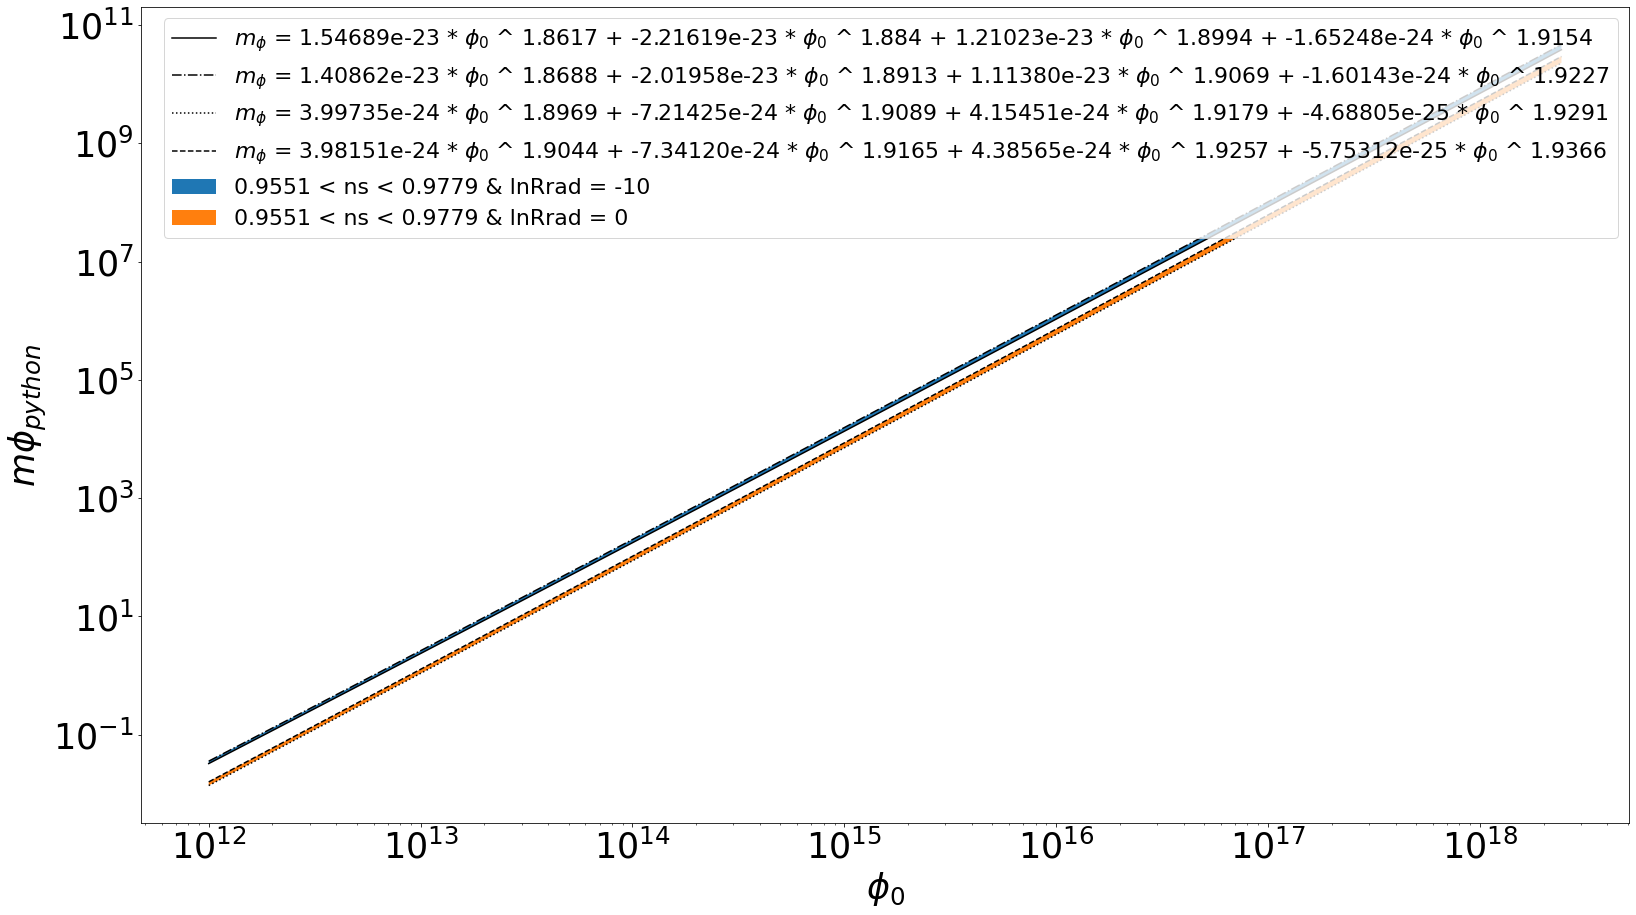

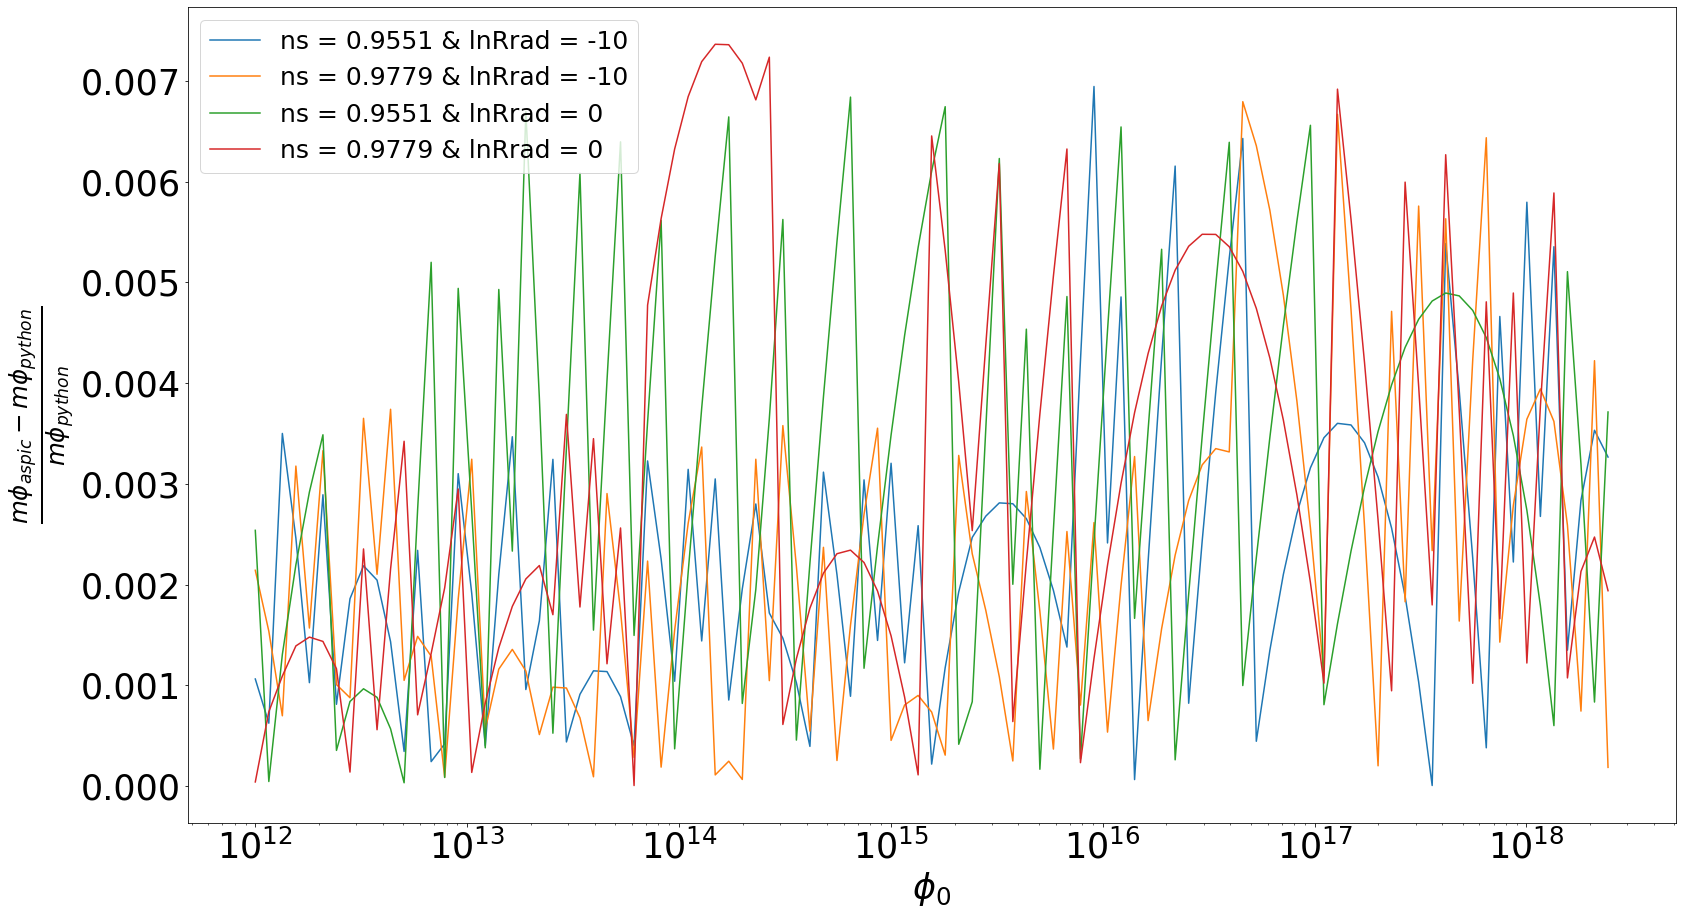

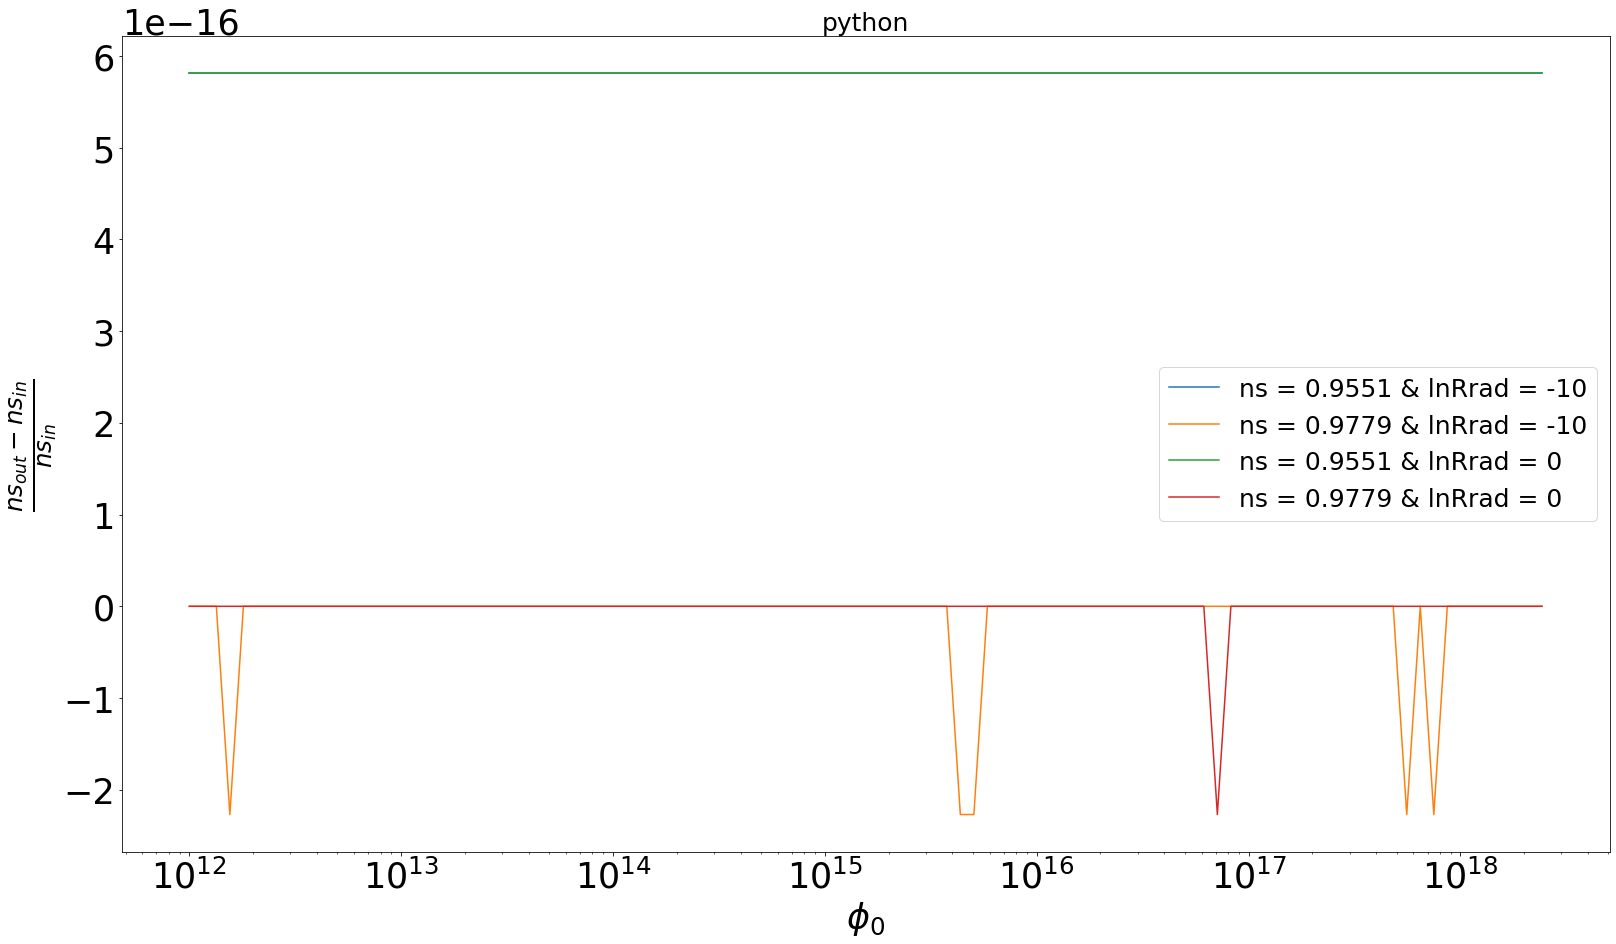

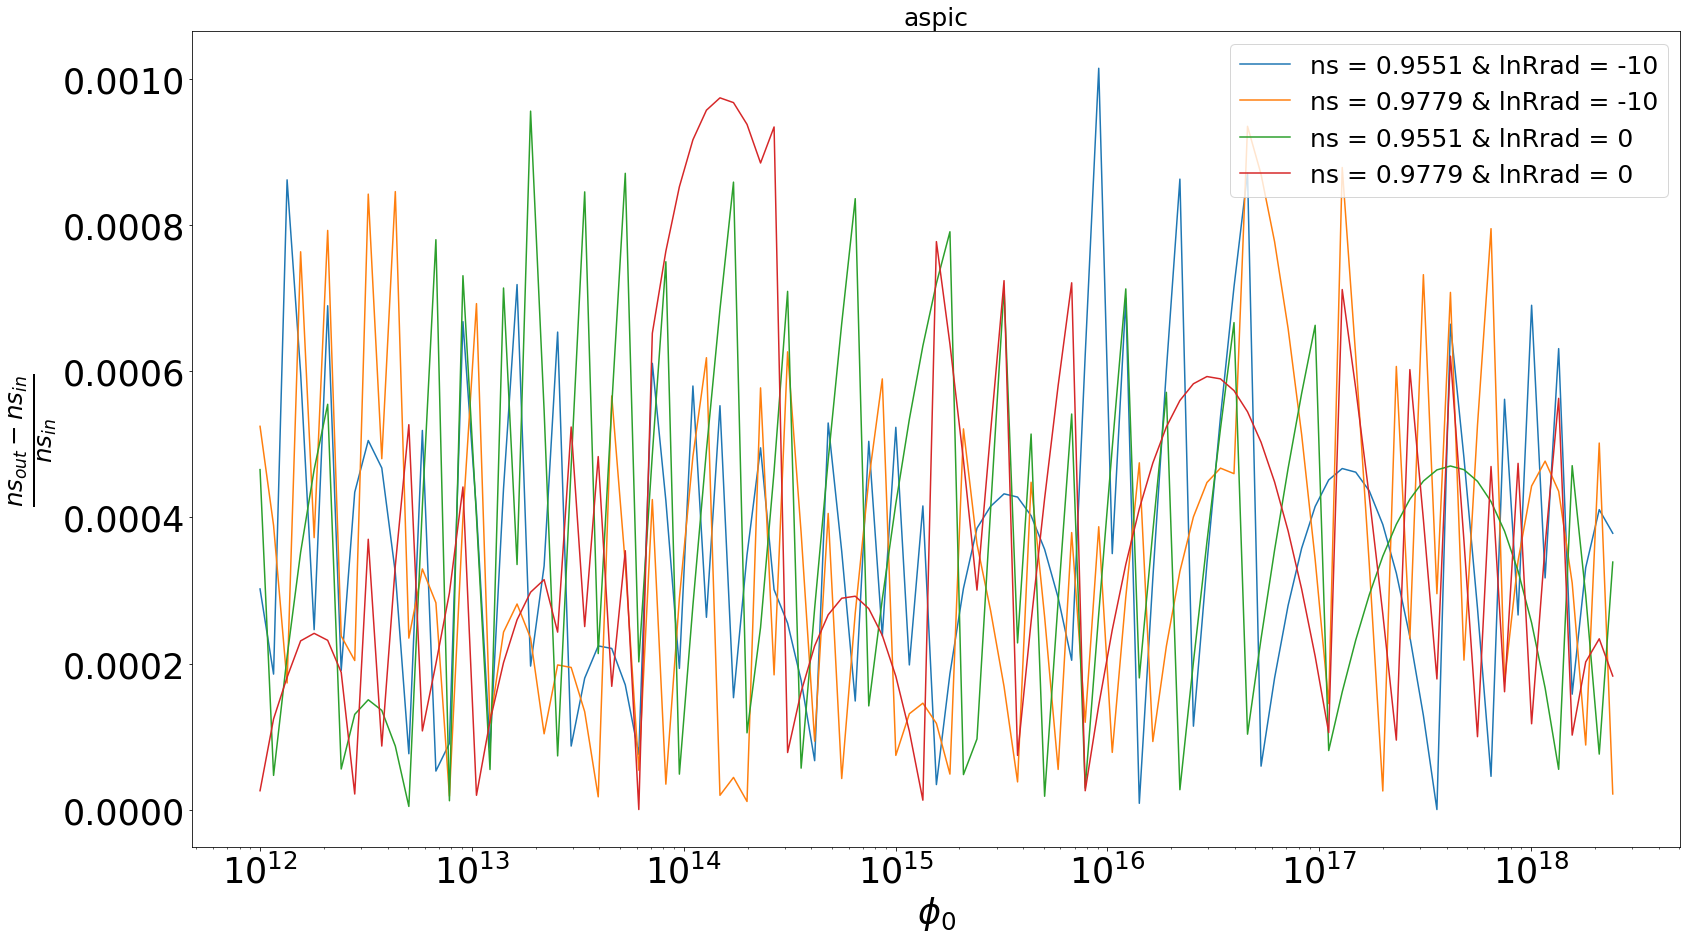

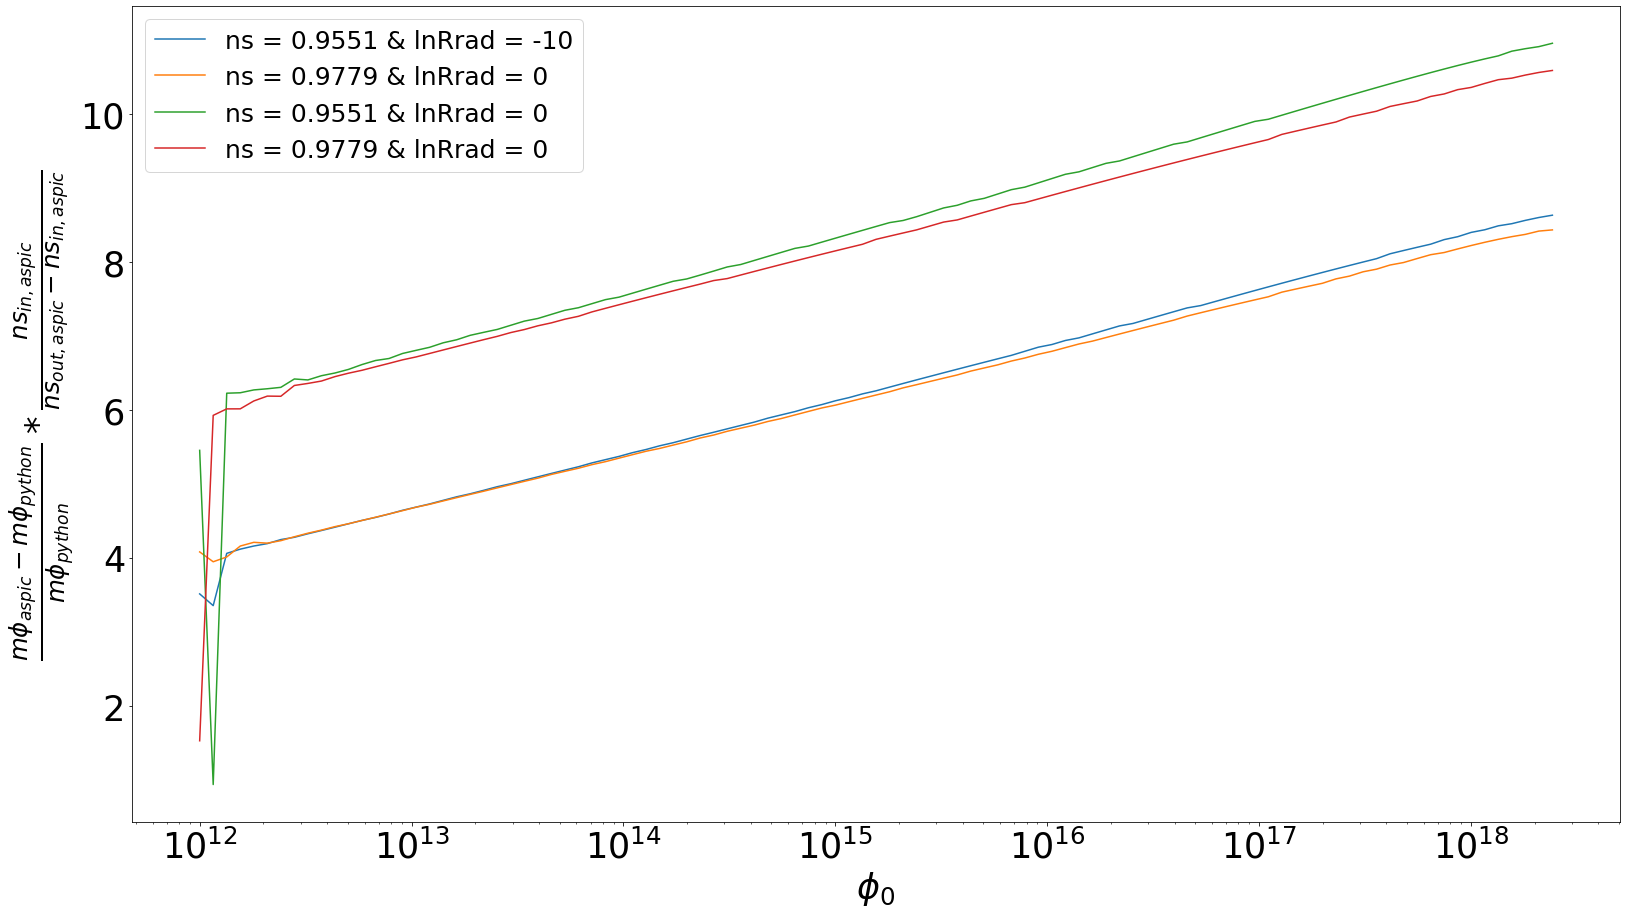

In [98]:
def pol_non_entier(x, A, u, B, v, C, w, D, t):
    return A*x**u+B*x**v+C*x**w+D*x**t

def sci(a):
    return("%.5e"%a)

aspic09551lnRradm10 = pd.read_csv('gmssmi_september_09551_lnRradm10.dat',delimiter="  ",names = ['phi0B','mphi','r','ns','Treh','lambdaB','AB'],engine='python')#,'phi0B','lambdaB','AB'
aspic09779lnRradm10 = pd.read_csv('gmssmi_september_09779_lnRradm10.dat',delimiter="  ",names = ['phi0B','mphi','r','ns','Treh','lambdaB','AB'],engine='python')#,'phi0B','lambdaB','AB'
aspic09779lnRrad0 = pd.read_csv('gmssmi_september_09779_lnRrad0.dat',delimiter="  ",names = ['phi0B','mphi','r','ns','Treh','lambdaB','AB'],engine='python')#,'phi0B','lambdaB','AB'
aspic09551lnRrad0 = pd.read_csv('gmssmi_september_09551_lnRrad0.dat',delimiter="  ",names = ['phi0B','mphi','r','ns','Treh','lambdaB','AB'],engine='python')#,'phi0B','lambdaB','AB'

python09551lnRradm10 = pd.read_csv('tree09551m10.csv', dtype = float, float_precision=5, index_col=0)
python09779lnRradm10 = pd.read_csv('tree09779m10.csv', dtype = float, float_precision=5, index_col=0)
python09779lnRrad0 = pd.read_csv('tree09779Inst.csv', dtype = float, float_precision=5, index_col=0)
python09551lnRrad0 = pd.read_csv('tree09551Inst.csv', dtype = float, float_precision=5, index_col=0)

plt.figure(0)
plt.fill_between(python09551lnRradm10['phi0B'],python09551lnRradm10['mphi'],python09779lnRradm10['mphi'], label='0.9551 < ns < 0.9779 & lnRrad = -10')
plt.fill_between(python09551lnRrad0['phi0B'],python09551lnRrad0['mphi'],python09779lnRrad0['mphi'], label='0.9551 < ns < 0.9779 & lnRrad = 0')

x = np.array(aspic09551lnRradm10['phi0B'])
linestyles = ['-','-.',':','--']
for i, name_file in enumerate([python09551lnRradm10, python09779lnRradm10, python09551lnRrad0, python09779lnRrad0]) :
    power = []
    n = 4
    y = np.array(name_file['mphi'])
    erry = y/10
    s = len(x)
    for k in range (n):
        xs,ys=x[k*s//n:(k+1)*s//n],y[k*s//n:(k+1)*s//n]
        power.append((np.log(ys[-1])-np.log(ys[0]))/(np.log(xs[-1])-np.log(xs[0])))
    par, par_va = curve_fit(lambda x, A, B, C, D : pol_non_entier(x, A, power[0], B, power[1], C, power[2], D, power[3]), x, y, p0=[1e-25,1e-25,1e-25,1e-25], sigma=erry, absolute_sigma=True)
    plt.plot(x, pol_non_entier(x,par[0],power[0],par[1],power[1],par[2],power[2],par[3],power[3]), linestyle=linestyles[i], color='black', label=r'$m_{\phi}$ = '+str(sci(par[0]))+' * '+r'$\phi_0$'+' ^ '+str(round(power[0],4))+' + '+str(sci(par[1]))+' * '+r'$\phi_0$'+' ^ '+str(round(power[1],4))+' + '+str(sci(par[2]))+' * '+r'$\phi_0$'+' ^ '+str(round(power[2],4))+' + '+str(sci(par[3]))+' * '+r'$\phi_0$'+' ^ '+str(round(power[3],4)))#+' * (1+'+str(sci(c0/1.2))+' * '+r'$\phi_0$'+' ^ '+str(sci(d0))+') * (1+'+str(sci(e0/0.15))+' * '+r'$\phi_0$'+' ^ '+str(sci(f0))+')')

plt.legend(fontsize=22)
define_plot_resolution()
plt.xlabel(r'$\phi_0$')
plt.ylabel(r'$m\phi_{python}$')
plt.loglog()


plt.figure(1)
plt.plot(aspic09551lnRradm10['phi0B'],(aspic09551lnRradm10['mphi']-python09551lnRradm10['mphi'])/python09551lnRradm10['mphi'], label='ns = 0.9551 & lnRrad = -10')
plt.plot(aspic09779lnRradm10['phi0B'],(aspic09779lnRradm10['mphi']-python09779lnRradm10['mphi'])/python09779lnRradm10['mphi'], label='ns = 0.9779 & lnRrad = -10')
plt.plot(aspic09551lnRrad0['phi0B'],(aspic09551lnRrad0['mphi']-python09551lnRrad0['mphi'])/python09551lnRrad0['mphi'], label='ns = 0.9551 & lnRrad = 0')
plt.plot(aspic09779lnRrad0['phi0B'],(aspic09779lnRrad0['mphi']-python09779lnRrad0['mphi'])/python09779lnRrad0['mphi'], label='ns = 0.9779 & lnRrad = 0')
plt.legend(fontsize=25)
define_plot_resolution()
plt.xlabel(r'$\phi_0$')
plt.ylabel(r'$\frac{m\phi_{aspic}-m\phi_{python}}{m\phi_{python}}$')
plt.semilogx()


plt.figure(2)
plt.plot(python09551lnRradm10['phi0B'],(python09551lnRradm10['ns']-0.9551)/0.9551, label='ns = 0.9551 & lnRrad = -10')
plt.plot(python09779lnRradm10['phi0B'],(python09779lnRradm10['ns']-0.9779)/0.9779, label='ns = 0.9779 & lnRrad = -10')
plt.plot(python09551lnRrad0['phi0B'],(python09551lnRrad0['ns']-0.9551)/0.9551, label='ns = 0.9551 & lnRrad = 0')
plt.plot(python09779lnRrad0['phi0B'],(python09779lnRrad0['ns']-0.9779)/0.9779, label='ns = 0.9779 & lnRrad = 0')
plt.legend(fontsize=25)
define_plot_resolution()
plt.title('python',fontsize=25)
plt.xlabel(r'$\phi_0$')
plt.ylabel(r'$\frac{ns_{out}-ns_{in}}{ns_{in}}$')
plt.semilogx()

plt.figure(3)
plt.plot(aspic09551lnRradm10['phi0B'],(aspic09551lnRradm10['ns']-0.9551)/0.9551, label='ns = 0.9551 & lnRrad = -10')
plt.plot(aspic09779lnRradm10['phi0B'],(aspic09779lnRradm10['ns']-0.9779)/0.9779, label='ns = 0.9779 & lnRrad = -10')
plt.plot(aspic09551lnRrad0['phi0B'],(aspic09551lnRrad0['ns']-0.9551)/0.9551, label='ns = 0.9551 & lnRrad = 0')
plt.plot(aspic09779lnRrad0['phi0B'],(aspic09779lnRrad0['ns']-0.9779)/0.9779, label='ns = 0.9779 & lnRrad = 0')
plt.legend(fontsize=25)
define_plot_resolution()
plt.title('aspic',fontsize=25)
plt.xlabel(r'$\phi_0$')
plt.ylabel(r'$\frac{ns_{out}-ns_{in}}{ns_{in}}$')
plt.semilogx()

plt.figure(4)
plt.plot(aspic09551lnRradm10['phi0B'],0.9551*(aspic09551lnRradm10['mphi']-python09551lnRradm10['mphi'])/(python09551lnRradm10['mphi']*(aspic09551lnRradm10['ns']-0.9551)), label='ns = 0.9551 & lnRrad = -10')
plt.plot(aspic09779lnRradm10['phi0B'],0.9779*(aspic09779lnRradm10['mphi']-python09779lnRradm10['mphi'])/(python09779lnRradm10['mphi']*(aspic09779lnRradm10['ns']-0.9779)), label='ns = 0.9779 & lnRrad = 0')
plt.plot(aspic09551lnRrad0['phi0B'],0.9551*(aspic09551lnRrad0['mphi']-python09551lnRrad0['mphi'])/(python09551lnRrad0['mphi']*(aspic09551lnRrad0['ns']-0.9551)), label='ns = 0.9551 & lnRrad = 0')
plt.plot(aspic09779lnRrad0['phi0B'],0.9779*(aspic09779lnRrad0['mphi']-python09779lnRrad0['mphi'])/(python09779lnRrad0['mphi']*(aspic09779lnRrad0['ns']-0.9779)), label='ns = 0.9779 & lnRrad = 0')
plt.legend(fontsize=25)
define_plot_resolution()
plt.xlabel(r'$\phi_0$')
plt.ylabel(r'$\frac{m\phi_{aspic}-m\phi_{python}}{m\phi_{python}}*\frac{ns_{in,aspic}}{ns_{out,aspic}-ns_{in,aspic}}$')
plt.semilogx()



.................................................. 1/50
.................................................. 2/50
.................................................. 3/50
.................................................. 4/50
.................................................. 5/50
.................................................. 6/50
.................................................. 7/50
.................................................. 8/50
.................................................. 9/50
.................................................. 10/50
.................................................. 11/50
.................................................. 12/50
.................................................. 13/50
.................................................. 14/50
.................................................. 15/50
.................................................. 16/50
.................................................. 17/50
........................................

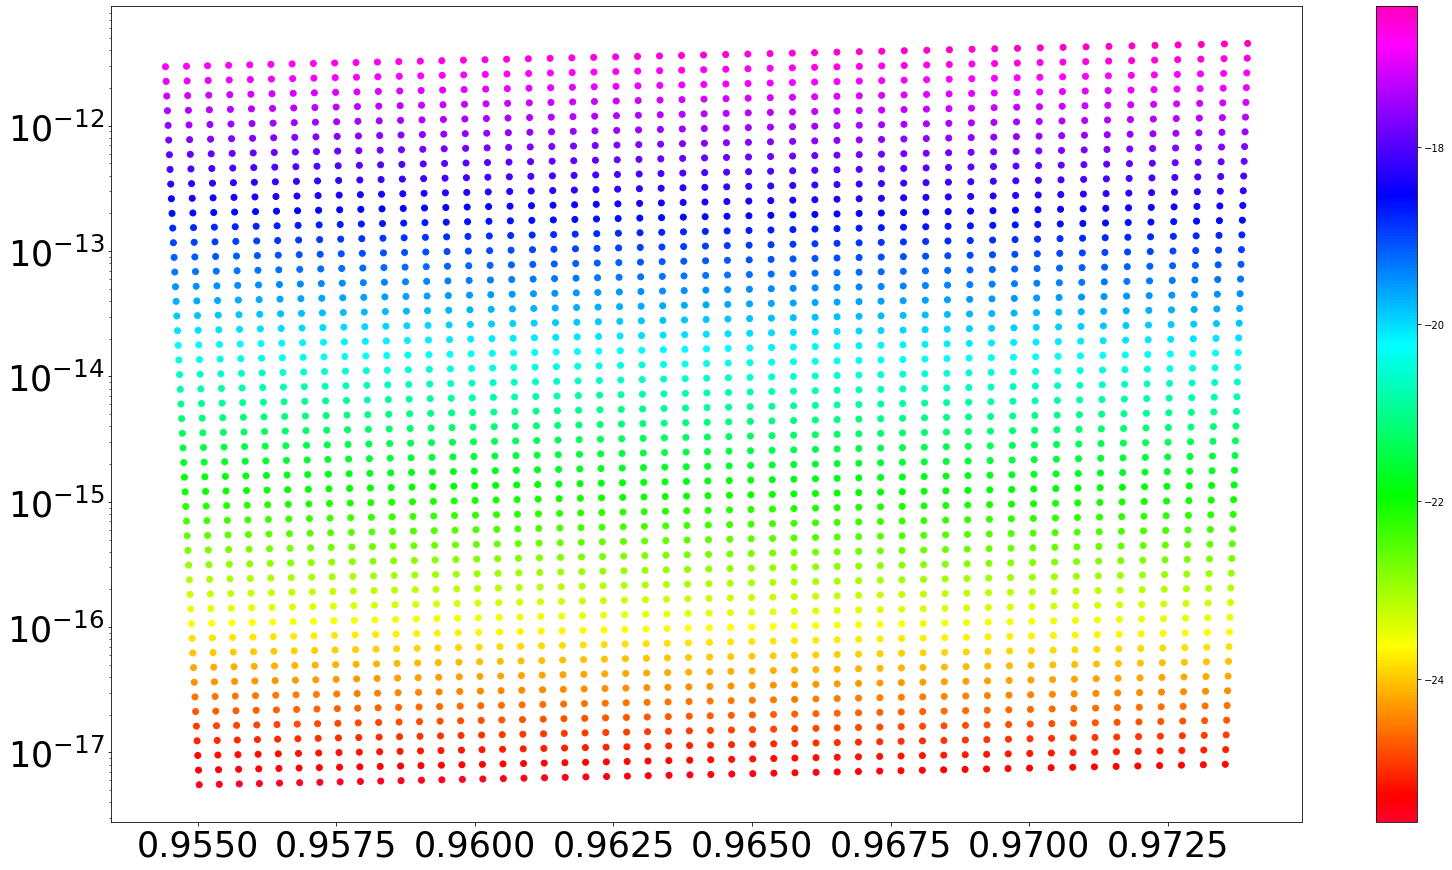

In [99]:
def ns_r_plan(phi0, alpha, lnRrad):
    xstar = x_rrad(alpha, phi0/Mp, lnRrad, Pstar)
    eps1 = norm_eps1(xstar,alpha,phi0/Mp)
    eps2 = norm_eps2(xstar,alpha,phi0/Mp)
    ns = 1-2*eps1-eps2
    r = 16*eps1
    return float(ns), float(r)

def generate_examples(phi0_start, alpha_start, delta_alpha):
    L = []
    for i in range(-18,32):
        print('.',end="", flush=True)
        alpha = alpha_start+i*delta_alpha
        L.append([*ns_r_plan(phi0_start, alpha, 0), float(mp.log(mp.fabs(1-alpha)))])
    return L

delta_alpha = [0.00000000000006*(0.0000000006/0.00000000000006)**(i/50) for i in range(50)]


phi0_start = np.array([mp.mpf(phi0) for phi0 in np.array(pd.read_csv('tree09665Inst.csv', dtype = str, index_col=0)['phi0B'])])
alpha_start = np.array([mp.mpf(phi0) for phi0 in np.array(pd.read_csv('tree09665Inst.csv', dtype = str, index_col=0)['alpha'])])

example_tot = []
for i in range(50):
    example_i = generate_examples(phi0_start[i], alpha_start[i], delta_alpha[i])
    example_tot = example_tot+example_i
    print(' '+str(i+1)+'/50')
example_tot = np.transpose(example_tot)


plt.figure(1)
plt.semilogy()
plt.scatter(example_tot[0], example_tot[1], c=example_tot[2], cmap = 'gist_rainbow' )
define_plot_resolution()
plt.colorbar()

print(example_tot)

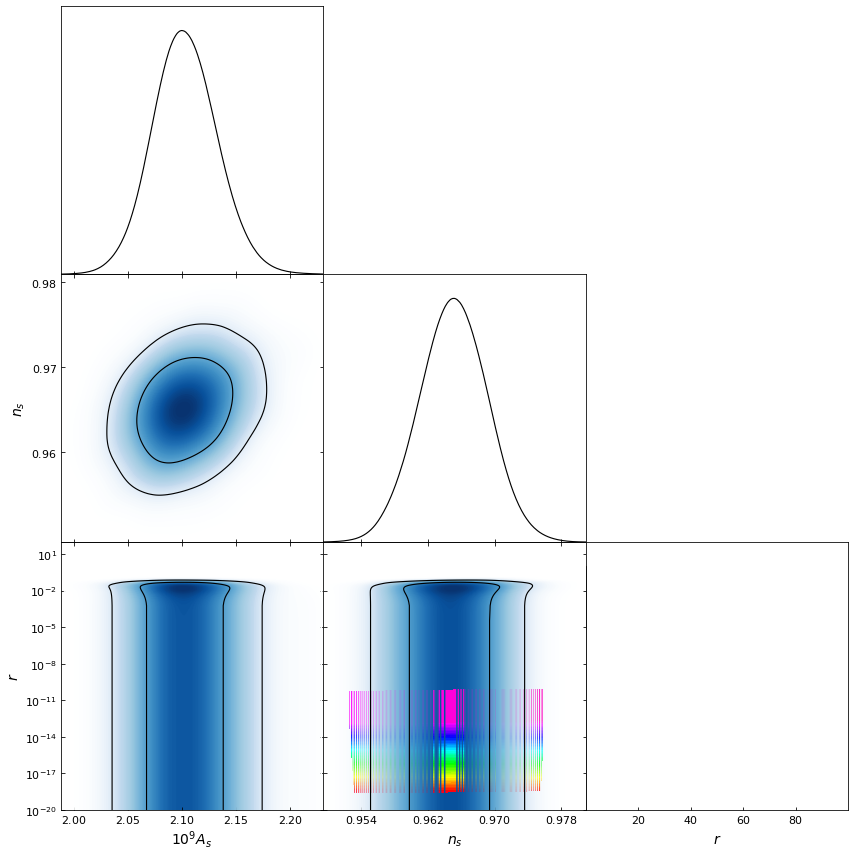

In [100]:
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

s = loadMCSamples('plikHM_TTTEEE_lowl_lowE_BK15_lensing/base_r_plikHM_TTTEEE_lowl_lowE_BK15_lensing')
plot = gdplt.get_subplot_plotter(subplot_size=4)
plot.triangle_plot(s, ['A','ns', 'r'], shaded = True)
nsr = plot.subplots[2,1]

nsr.semilogy()
nsr.axis(ymin=10**-20,ymax=100)
nsr.scatter(example_tot[0], example_tot[1], c=example_tot[2], cmap = 'gist_rainbow', marker = 's', s=1000)

# plot.fig.savefig('test.png')

#### next order in slow roll

In [ ]:
CConst = mp.euler+mp.log(2)-mp.mpf('2')
Cconst = CConst
C = CConst

def norm_eps3(x,alpha,phi0):
    return (mp.mpf('60')*(mp.mpf('1')+alpha*x**4*(-mp.mpf('2')+x**mp.mpf('4')))*(mp.mpf('225')+alpha*x**mp.mpf('4')*(-mp.mpf('1350')+x**4*(mp.mpf('3915')+alpha*(-mp.mpf('2100')+mp.mpf('20')*(mp.mpf('81')-mp.mpf('10')*alpha)*x**4+mp.mpf('15')*(-mp.mpf('99')+mp.mpf('20')*alpha)*x**mp.mpf('8')+mp.mpf('90')*alpha*x**mp.mpf('12')+mp.mpf('9')*alpha*x**16)))))/(x**2*(mp.mpf('15')+alpha*x**mp.mpf('4')*(-mp.mpf('10')+mp.mpf('3')*x**4))**2*(mp.mpf('15')+alpha*x**4*(mp.mpf('40')+x**4*(-mp.mpf('78')+alpha*(mp.mpf('20')+mp.mpf('3')*x**8)))))/phi0**2

def find_reheat_rrad_anyorder(nuStar,calFplusNuEnd,epsStarVec,Vstar):
    return nuStar - calFplusNuEnd + mp.mpf('0.25')*mp.log((mp.mpf('9')-mp.mpf('3')*epsStarVec[0])/(epsStarVec[0]*Vstar)) + mp.mpf('0.25')*mp.log(slowroll_corrections(epsStarVec))

def slowroll_corrections(epsV):   
    return hubbleflow_corrections(slowroll_to_hubble(epsV))

def slowroll_to_hubble(epsV):
    epsVnp1 = mp.mpf('0')
    neps = len(epsV)
    
    if neps == 1 or neps==2:
        return epsV
    elif neps == 3:
        a = epsV[0] * (mp.mpf('1') - epsV[1]/3)
        b = epsV[1] * (mp.mpf('1') - epsV[1]/6 - epsV[2]/3)
        c = epsV[2] * (mp.mpf('1') - epsV[1]/3 - epsVnp1/3)
        epsH = [a, b, c]
    else:
        print('slowroll_to_hubble: order not implemented!')
        return mp.mpf('nan')
    return epsH


def hubbleflow_corrections(epsH):
    neps = len(epsH)
    if neps == 1:
        hubbleflow_corrections = mp.mpf('1')
       
    elif neps == 2 :
        hubbleflow_corrections = mp.mpf('1') - 2*(mp.mpf('1')+Cconst)*epsH[0] - CConst*epsH[1]

    elif neps == 3 :
        hubbleflow_corrections = mp.mpf('1') - 2*(mp.mpf('1')+Cconst)*epsH[0] - CConst*epsH[1] + (mp.mpf('-3') + 2*CConst + 2*CConst**2 + mp.pi**2/2)*epsH[0]**2 + (mp.mpf('-6') - Cconst + CConst**2 + mp.mpf('7')*mp.pi**2/12)*epsH[0]*epsH[1] + (mp.mpf('-1') + CConst**2/2 + mp.pi**2/8)*epsH[1]**2 + (-CConst**2/2 + mp.pi**2/24)*epsH[1]*epsH[2]
    else:
        print('inverse_slow_corrections: order not implemented!')
        return mp.mpf('nan')
    return hubbleflow_corrections

def scalar_running(eps1, eps2, eps3):
    return -2*eps1*eps2-eps2*eps3

def scalar_index_NLO(eps1, eps2, eps3):
    return 1-2*eps1-eps2-2*eps1**2-(3+2*C)*eps1*eps2-C*eps2*eps3

phi0 = mp.mpf('7.68108547225326848E+17')
x = mp.mpf('0.99998603962689958')
alpha = mp.mpf('0.99999997217031388')

nuStar = efold_primitive(x,alpha,phi0/Mp)
Vstar = norm_potential(x,alpha,phi0/Mp)
epsStarVec = [norm_eps1(x, alpha, phi0/Mp),norm_eps2(x, alpha, phi0/Mp),norm_eps3(x, alpha, phi0/Mp)]

xEnd = x_endinf(alpha,phi0/Mp)
epsOneEnd = norm_eps1(xEnd,alpha,phi0/Mp)
potEnd = norm_potential(xEnd,alpha,phi0/Mp)
calFplusNuEnd = get_calfconst_rrad(0, Pstar,epsOneEnd,potEnd)+efold_primitive(xEnd,alpha,phi0/Mp)
